In [168]:
from kwant.physics.leads import unified_eigenproblem, setup_linsys # should be a relative import when in kwant
import numpy as np
import scipy.linalg as la
import scipy.sparse as sp

def fill_zero_with_nan(array):
    """
    Replace all elements equal to 0 by nan so that it is 
    not plotted by pyplot
    """
    S = array.shape
    array = np.reshape(array, S[0] * S[1])
    for i, element in enumerate(array):
        if element != 0:
            array[i] = element
        else:
            array[i] = float('nan')
    return np.reshape(array, (S[0], S[1]))

def leads_modes(H_leads, V_leads, E, need_orth=True):
    """
    Compute the evanescent modes for every lead separetly
    """
    X_out_leads = []
    L_out_leads = []
    assert len(H_leads)==len(V_leads), 'Check the number of leads'

    for H, V in zip(H_leads, V_leads): #compute the modes of every lead
        L_out, X_out = extract_out_modes(H, V, E, need_orth=need_orth)

        X_out_leads.append(X_out)
        L_out_leads.append(L_out)
    return L_out_leads, X_out_leads

def block_diag(*arrs):
    """
    Copied from old version of scipy, v0.8.0
    Create a block diagonal matrix from the provided arrays.

    Given the inputs `A`, `B` and `C`, the output will have these
    arrays arranged on the diagonal::

        [[A, 0, 0],
         [0, B, 0],
         [0, 0, C]]

    If all the input arrays are square, the output is known as a
    block diagonal matrix.

    Parameters
    ----------
    A, B, C, ... : array-like, up to 2D
        Input arrays.  A 1D array or array-like sequence with length n is
        treated as a 2D array with shape (1,n).

    Returns
    -------
    D : ndarray
        Array with `A`, `B`, `C`, ... on the diagonal.  `D` has the
        same dtype as `A`.

    References
    ----------
    .. [1] Wikipedia, "Block matrix",
           http://en.wikipedia.org/wiki/Block_diagonal_matrix

    Examples
    --------
    >>> A = [[1, 0],
    ...      [0, 1]]
    >>> B = [[3, 4, 5],
    ...      [6, 7, 8]]
    >>> C = [[7]]
    >>> print(block_diag(A, B, C))
    [[1 0 0 0 0 0]
     [0 1 0 0 0 0]
     [0 0 3 4 5 0]
     [0 0 6 7 8 0]
     [0 0 0 0 0 7]]
    >>> block_diag(1.0, [2, 3], [[4, 5], [6, 7]])
    array([[ 1.,  0.,  0.,  0.,  0.],
           [ 0.,  2.,  3.,  0.,  0.],
           [ 0.,  0.,  0.,  4.,  5.],
           [ 0.,  0.,  0.,  6.,  7.]])

    """
    if arrs == ():
        arrs = ([],)
    arrs = [np.atleast_2d(a) for a in arrs]

    bad_args = [k for k in range(len(arrs)) if arrs[k].ndim > 2]
    if bad_args:
        raise ValueError("arguments in the following positions have dimension "
                            "greater than 2: %s" % bad_args) 

    shapes = np.array([a.shape for a in arrs])
    out = np.zeros(np.sum(shapes, axis=0), dtype=arrs[0].dtype)

    r, c = 0, 0
    for i, (rr, cc) in enumerate(shapes):
        out[r:r + rr, c:c + cc] = arrs[i]
        r += rr
        c += cc
    return out

def extract_out_modes(H, V, E, return_mat=False, need_orth=True):
    """
    parameters:
    H: hamiltonian inside the unit cell of the lead
    V: hoppings between the cells
    E: Energy at which the mode is calculated
    need_orth: bool, if True it returns orthogonalized 
                eigenvectors Phi_e, only necessary for degenerate evs
    
    returns:
    modes: a list of evanescent right going modes
    Normalization of X_out is such that max(X_out[:, i]) = 1
    """
    n = H.shape[0]
    Id = np.eye(n)
    H = H - E * Id
    V_dag = V.conj().T

    matrices, v, extract = setup_linsys(H, V, stabilization=(True, True))
    all_lmb, evanselect, propselect, vec_gen, ord_schur = unified_eigenproblem(*(matrices))
    lmb_inv = all_lmb[evanselect]
    all_vecs = vec_gen(evanselect)
    Phi = np.zeros(shape=(n, len(lmb_inv)), dtype=complex)

    for i, l in enumerate(lmb_inv):
        phi = extract(all_vecs[:, i], l)
        phi /= np.sqrt(np.dot(phi.conj().T, phi))
        Phi[:, i] = phi

    Phi, arg_max, max_x = max_norm(Phi)

    if need_orth:
        if len(lmb_inv):
            Q, R = np.linalg.qr(Phi)
            Phi = Q
            R_inv = la.solve(R, np.eye(R.shape[0]))
            L = R.dot(np.diag(1 / lmb_inv)).dot(R_inv)
        else: L = np.zeros(shape=(len(lmb_inv), 0), dtype=complex)
    else:
        L = np.diag(1 / lmb_inv)

    if return_mat:
        return L, Phi, R
    else:
        return L, Phi

def extract_kwant_matrices(sys, sparse=False, args=(), params=None):
    """
    Function that takes a finalized kwant system (with at least one lead)
    and returns the matrices defining the onsite and hoppings in the 
    system.
    Parameters:
    sys: a kwant system with at least one lead
    sparse: whether to return sparse or dense matrices
    args : tuple
    Positional arguments to the system.
    params : dict
        Keyword arguments to the system.
    Returns:
    H_s: Hamiltonian of the scattering region
    H_leads: list countaining the hamiltonians of the unit cells of the 
             leads
    V_leads: list countaining the hoppings between the unit cells of the 
             leads
    transf: Rectangular matrix full of 0s and 1s that connects the lead 
            and the scattering region. transf[i, j] = 1 only if the site
            i from the lead and the site j from the scattering region 
            have a non-zero hopping.
    """

    assert(len(sys.leads)), print('The system should be infinite')

    H_s, norb, _ = sys.hamiltonian_submatrix(sparse=sparse,
                                             args=args, params=params,
                                             return_norb=True)
    H_leads = []
    V_leads = []
    coords = []
    for i, lead in enumerate(sys.leads):
        # H and V are not written in sparse at this point because the 
        # mode solver needs a numpy array
        H_leads.append(sys.leads[i].cell_hamiltonian(args=args, params=params))
        V_leads.append(sys.leads[i].inter_cell_hopping(args=args, params=params))
        coords = np.concatenate((coords, sys.lead_interfaces[i]))

    offsets = np.empty(norb.shape[0] + 1, int)
    offsets[0] = 0
    offsets[1 :] = np.cumsum(norb)
    ones = []
    for coord in coords:
        coord = int(coord)
        for i in range(offsets[coord], offsets[coord] + np.array(norb)[coord]):
            ones.append(i)

    if sparse:
        transf = sp.csr_matrix((np.ones(len(ones)), (range(len(ones)),ones)),
                                shape=(len(ones),sum(norb)))
    else:
        # most inefficient way to create a dense array, to change at some point
        transf = sp.csr_matrix((np.ones(len(ones)), (range(len(ones)),ones)),
                                shape=(len(ones),sum(norb))).toarray()

    return H_s, H_leads, V_leads, transf

def compute_wf(vals, vecs, L_leads, X_out_leads, scat_dim,
               tol=1e-4, schur_modes=False):
    """
    Extract and normalize the wavefunction from the eigenvectors of 
    the lhs (H_eff) matrix.

    vals: eigenvalues of H_eff computed at the energy of the bound state
    vecs: eigenvectors of H_eff computed at the energy of the bound state
    L_leads: list of matrices with the evanescent modes in
    X_leads:
    scat_dim: int, number of sites in the scattering region
    schur_modes: if True, bound state is returned in schur basis, it is 
                returned in the basis with Lambda diagonal otherwise
    """
    zero_schur = (abs(vals) < tol)
    # Psi_alpha_0 is the wavefunction of the bound states in the
    # system.
    psi_alpha_0, q_e = vecs[:scat_dim, zero_schur], vecs[scat_dim:, zero_schur]
    #print('hello!')
    #print('in spyder')
    #print(psi_alpha_0)
    print('pre q_e')
    print(q_e)

    Q = block_diag(*X_out_leads)
    L_out = block_diag(*L_leads)

    # When modes are degenerated, Lambda is not diagonal anymore
    lmb, R = la.eig(L_out)
    # R is already computed in extract_out_modes, is it faster to keep it in memory?
    Phi = Q @ R
    #my own tweek
    q_e = np.linalg.inv(R) @ q_e
    #validation
    print('L_out')
    print(L_out)
    print(R@np.diag(lmb)@np.linalg.inv(R))

    N = Phi.conj().T @ Phi
    #print('N')
    #print(N.shape)
    #print(N)
    
    #print(enumerate(lmb))

    for i, l1 in enumerate(lmb):
        for j, l2 in enumerate(lmb):
            ll = np.conj(l1) * l2
            N[i, j] *= ll / (1 - ll)
    #print('new N')
    #print(N)

    for i, psi in enumerate(psi_alpha_0.T): #loop if degeneracy
        #print(i)
        #print(psi)
        a = q_e[:, i]
        #print(a)
        norm = psi.conj().T @ psi
        #print(norm)
        norm += a.conj().T @ N @ a
        #print(norm)
        norm = np.sqrt(norm)
        print('norm 1')
        print(norm)
        psi_alpha_0[:, i] /= norm
        q_e[:, i] /= norm
        
    for i, psi in enumerate(psi_alpha_0.T): #loop if degeneracy
        #print(i)
        #print(psi)
        a = q_e[:, i]
        #print(a)
        norm = psi.conj().T @ psi
        #print(norm)
        norm += a.conj().T @ N @ a
        #print(norm)
        norm = np.sqrt(norm)
        print('norm 2')
        print(norm)
        #psi_alpha_0[:, i] /= norm
        #q_e[:, i] /= norm
    
    #print('R')
    #print(R)

    if schur_modes:
        return psi_alpha_0, q_e, L_out, Q
    else:
        return psi_alpha_0, q_e, np.diag(lmb), Phi

def max_norm(X):
    """
    Norm every column of X such that the maximum value of the column is equal to 1
    """
    X_tilde = np.zeros(X.shape, dtype=complex)
    arg_max, max_x = [], []

    for i, x in enumerate(X.T):
        x_max = np.argmax(abs(x)) # take the maximum to avoid division by small numbers
        X_tilde[:, i] = x / x[x_max]
        arg_max.append(x_max)
        max_x.append(x[x_max])
    return X_tilde, arg_max, max_x

In [169]:
import numpy as np
import scipy.linalg as la
from scipy.optimize import minimize_scalar
import scipy.sparse as sp

def BS_finder(H_s, H_leads, V_leads, transf, e_range, sparse=False,
              eps=1e-6, sigma=None, tol=1e-8, sing_values=4, uv=False):
    """
    Finds the minimum of the singular values of L in e_range.
    If the singular value is smaller than eps, then it returns 
    the energy of the bound state.
    Parameters:
    e_range: tuple countaining the minimum and the maximum of the 
             energy range
    
    returns:
    E: energy of the bound state if minimal singular value is smaller
        than eps
    None otherwise
    eps: float, if the minimal singular value found by minimize_scalar is
        smalle than eps, then it consider you found a bound state
    tol: float, function minimize_scalar stops only if the minimum of the 
        previous step is closer than tol (or something like that). Should
        be smaller than eps
    
    Comment about the parameters tol and eps:
    At which scale do we consider a minimum as a bound state and not 
    as a singular value close to zero?
    It would be good to compare the zero found in the minimizer with 
    quantities coming from the system itself (the size of the gap? but 
    not all systems are gapped, the width of the band structure? the 
    biggest singular value?).
    """

    def dumb(e):
        s = min(singular_values(H_s, H_leads, V_leads, transf, e, 
                                sparse=sparse, uv=False, sigma=sigma,
                                sing_values=sing_values))
        return s

    minimum = minimize_scalar(dumb, method='Bounded', bounds=e_range, options={'xatol': tol})
    if minimum.fun < eps:
        # if the last singular value is smaller than eps,
        # then there is a bound state.
        E = minimum.x
        if not uv:
            return E
        else:
            S, Wh, L_out, X_out = singular_values(H_s, H_leads, V_leads,
                                                  transf, E, sparse=sparse,
                                                  uv=True, sigma=sigma,
                                                  sing_values=sing_values)
            return E, S, Wh, L_out, X_out
    else:
        return None

def BS_solver(H_s, H_leads, V_leads, transf, E, eps=1e-4, sparse=False, sigma=None):
    """
    Returns the elements to compute the wavefunction of a bound state
    Raise an error if there is no bound state (singular value > eps)
    Parameters:
    transf: numpy array or sparse csr matrix. V.dot(transf) gives the 
    hopping matrix between the scattering region and the leads.
    """

    S, Wh, L_leads, X_out_leads = singular_values(H_s, H_leads, V_leads, transf, E,
                                      sparse=sparse, uv=True, sigma=sigma)
    assert(min(S) < eps), 'The energy does not match the bound state energy, {0}'.format(min(S)) 
    N = H_s.shape[0]
    W = Wh.conj().T
    return compute_wf(S, W, L_leads, X_out_leads, N, eps=eps)

def hopping_svd(V_leads, eps=1e-4):
    """
    Check if one or several hopping matrices in the lead are not 
    invertible and replace them by their SVD in the former case.
    """
    DBh_leads = []
    for V in V_leads:
        _, D, Bh = la.svd(V)
        # keep only the vectors assiocated with non zero singular value
        non_zeros = sum(D > eps)
        D = np.diag(D[:non_zeros])
        Bh = Bh[:non_zeros, :]
        DBh = np.dot(D, Bh)
        DBh_leads.append(DBh)

    return DBh_leads

def singular_values(H_s, H_leads, V_leads, transf, E, sparse=False,
                    uv=True, sing_values=4, eps=1e-4, sigma=None,
                    need_orth=True):
    """
    Solver that returns the singular values of the SVD of 
    the left hand side of the bound state equation (L in the notes)
    
    Parameters:
    H_s: Hamiltonian of the central system
    H_leads: tuple, countains the onsite matrices of the unit cells of the leads
    V_leads: tuple, countains the hopping matrices between the unit 
        cells of every lead
    uv: Whether to compute the the full SVD of the matrix L 
        or only the singular values
    returns:
    if uv is false: the singular values of the matrix L
    else: 
    S: The singular values of L 
    Wh: The right matrix of the svd decomposition
    L: array that countains the evanescent outgoing lambdas
    X_out: Columns are the corresponding evanescent wavefunctions
    """
    L_out_leads, X_out_leads = leads_modes(H_leads, V_leads, E,
                                           need_orth=need_orth)

    lhs = setup_lhs(H_s, V_leads, transf, L_out_leads, X_out_leads, E, 
                    sparse=sparse)
    print('lhs')
    print(lhs.shape)

    if sparse:
        B = sp.coo_matrix.dot(lhs.conj().T, lhs)
        if sigma is None:
            # First compute the biggest eigenvalue
            max_eval = sp.linalg.eigsh(B, k=1, which='LM', return_eigenvectors=False)[0]
            # shift the matrix so that the lowest eigenvalue become the biggest in magnitude
            B = -B + 2 * max_eval * sp.eye(B.shape[0])
        if not uv:
            try: # if the singular value is exactly zero
                evals = sp.linalg.eigsh(B, return_eigenvectors=False, which='LM',
                                        k=sing_values, sigma=sigma)
            except RuntimeError:
                evals = sp.linalg.eigsh(B + eps*sp.eye(B.shape[0]), 
                                        which='LM', 
                                        return_eigenvectors=False, 
                                        k=sing_values, sigma=sigma)
                evals -= eps
            if sigma is None: # that is, use the shift method 
                return np.sqrt(2 * max_eval - evals)
            else: # use of the shift invert method
                return np.sqrt(evals)
        else:
            try:
                evals, evecs = sp.linalg.eigsh(B, return_eigenvectors=True, 
                                                k=sing_values, sigma=sigma,
                                                which='LM')
            except RuntimeError:
                evals, evecs = sp.linalg.eigsh(B + eps*sp.eye(B.shape[0]), 
                                                which='LM', 
                                                return_eigenvectors=True, 
                                                k=sing_values, sigma=sigma)
                evals -= eps
            if sigma is None: # shift method
                return np.sqrt(2 * max_eval - evals), evecs.T, L_out_leads, X_out_leads
            else: # shift invert method
                # If an eigenvalue is negative due to numerical 
                # precision, then it is replaced by 0
                evals = np.clip(evals, 0, np.inf)
                return np.sqrt(evals), evecs.T, L_out_leads, X_out_leads
    else:
        if not uv:
            return la.svd(lhs, compute_uv=False)
        else:
            U, S, Wh = la.svd(lhs, compute_uv=True)
            return S, Wh, L_out_leads, X_out_leads

def setup_lhs(H_s, V_leads, transf, L_out_leads, X_out_leads, E, sparse=False):
    """
    Setup the left hand side of the equation to find bound states.
    """
    DBh_leads = hopping_svd(V_leads)
    DBh = block_diag(*DBh_leads)
    L_out = block_diag(*L_out_leads)
    X_out = block_diag(*X_out_leads)
    V = block_diag(*V_leads)

    if sparse: #Uses either scipy.sparse if sparse of numpy if dense
        d = sp.csr_matrix.dot
        lin = sp
        DBh, V = sp.csr_matrix(DBh), sp.csr_matrix(V)
        L_out, X_out = sp.csr_matrix(L_out), sp.csr_matrix(X_out)
        # V is a csc matrix because it is transposed later and it becomes a csr matrix
    else:
        d = np.dot
        lin = np

    Id_N = lin.eye(H_s.shape[0])
    DBh_ls = d(DBh, transf)
    V_ls = V.dot(transf)

    lhs = lin.hstack([H_s - E * Id_N, V_ls.conj().T.dot(d(X_out, L_out))])
    lhs = lin.vstack([lhs, lin.hstack([DBh_ls, -d(DBh, X_out)])])
    return lhs

def plot_singular_values(sys, e_min, e_max, N=500, sparse=False, sigma=None,
                        k=5):
    energies = np.linspace(e_min, e_max, N)

    H_s, H_leads, V_leads, transf = extract_kwant_matrices(sys, sparse=sparse)

    if sparse:
        dumb = np.zeros(shape=(N, k))
    else:
        # at maximum the number of singular value is the dimension of H_s
        # + the dimension of all the leads together
        dumb = np.zeros(shape=(N, H_s.shape[0] + sum(V.shape[0] for V in V_leads)))
        # the zeros are later replaced with NaN so they are not plotted.

    for i, e in enumerate(energies):
        s = singular_values(H_s, H_leads, V_leads, transf, e, sparse, 
                            uv=False, sigma=sigma, sing_values=k)

        dumb[i, :len(s)] = s
        dumb = fill_zero_with_nan(dumb)

    return (energies, dumb)



In [170]:
# Copyright 2011-2018 Kwant authors.
#
# This file is part of Kwant.  It is subject to the license terms in the file
# LICENSE.rst found in the top-level directory of this distribution and at
# http://kwant-project.org/license.  A list of Kwant authors can be found in
# the file AUTHORS.rst at the top-level directory of this distribution and at
# http://kwant-project.org/authors.

import numpy as np
from scipy.optimize import newton, brentq, minimize_scalar

__all__ = ['bound_state', 'wf_in_leads']

def bound_state(syst, E_range, args=(), params=None, tol=1e-8, sparse=False, 
                return_wf=False, maxiter=100, eig_val=2, need_orth=True):
    """Find a single bound state in the energy window '(emin, emax)'.

    Parameters
    ----------
    syst : kwant.system.FiniteSystem
        Must have at least one lead attached. If you need to find bound
        states of a finite system, use an eigensolver.
    emin, emax : float
        The energy bounds in which to search for bound states.
    E_0: starting point of the newton method
    args : tuple
        Positional arguments to the system.
    params : dict
        Keyword arguments to the system.
    eps : float
        Tolerance with which to find the bound state.
    return_wavefunction : bool
        Whether or not to return the bound state wavefunction.
    maxiter: maximum number of steps used by the newton method
    eig_val: the number of eigenvalue to be computed. Only if sparse 
             is True
    need_orth: Whether to orthogonalize the leads modes. Only necessary 
               for degenerate eigenmodes

    Returns
    -------
    E: energy of the bound state
    if return _wf is True:
        psi_alpha_0: wavefunction in the scattering region
        lmb: Evanescent modes in the lead at a given energy
        q_e: 
        Phi: 
    elements fo compute the wavefunction in the leads

    Notes
    -----
    TODO: finish this docstring
    Can use Newton method to find the root. Downside of this method: 
    -needs a good initial guess (i.e. first Taylor expansion term bigger
     than others) 
    -assume that the minimal eigenvalue is a smooth function, which is 
     not the case when a mode opens in the lead, or when the minimal 
     eigenvalue changes
    Upside: Fast
    Brentq:
    from scipy, "Generally considered the best of the rootfinding routines here"

    Returns at most 1 bound state...
    """
    mat = extract_kwant_matrices(syst, sparse=sparse, args=args, params=params)

    # To use Singular value decomposition and look for a minimum
    return SVD_formulation(mat, E_range, tol, return_wf=return_wf, sparse=sparse)
    # To use eigenvalue decomposition and look for a root
    # return Hermitian_formulation(mat, E_0, return_wf=return_wf)

def SVD_formulation(mat, E_range, tol, return_wf=False, sparse=False, sigma=None, sing_values=1):
    """
    Compute the singular values of Eq.11
    """
    def min_sing(e):
        return min(singular_values(*mat, e, sparse=sparse, uv=False, sing_values=1))

    minimum = minimize_scalar(min_sing, method='Bounded', bounds=E_range, 
                              options={'xatol': tol})
    if minimum.fun > tol:
        print(minimum.fun)
        return None

    E = minimum.x
    if return_wf:
        #print('here')
        #print(minimum)
        S, Wh, L_out, X_out = singular_values(*mat, E, sparse=sparse,
                                              uv=True, sigma=sigma,
                                              sing_values=sing_values)
        print('sing values')
        print(S)
        print(Wh.conj().T[:,-1])
        print('L_out')
        print(L_out)
        print('X_out')
        print(X_out)
        
        psi_alpha_0, q_e, L_out, Phi = compute_wf(S, Wh.conj().T, L_out, 
                                                X_out, mat[0].shape[0], 
                                                tol=tol,schur_modes=False)
        return E, psi_alpha_0, q_e, L_out, Phi
    else:
        return E

'''def Hermitian_formulation(mat, E_0, return_wf=False, fprime=eig_val_derivative):

    def min_eig(e, *mat, sparse=sparse):
        eig = eig_values(*mat, e, sparse=sparse, uv=False, sing_values=1)
        idx = np.argmin(abs(eig))
        return eig[idx]

    try:
        E = newton(min_eig, E_0, fprime=fprime, tol=tol, args=(*mat, sparse))

        if not false_positive_BS(*mat, E, eps=eps):
            print('False positive, no bound state')
            return None
        if return_wf:
            S, Wh, L_out, X_out = eig_values(*mat, E, sparse=sparse,
                                             uv=True)
            psi_alpha_0, q_e, L_out, Phi = compute_wf(S, Wh.conj().T, L_out, 
                                                X_out, mat[0].shape, 
                                                tol=tol,schur_modes=False)
            return E, psi_alpha_0, q_e, L_out, Phi
        else:
            return E

    except RuntimeError:
        print('no bound states found')'''

def wf_in_leads(q_e, L_out, Phi, j):
    """
    Compute the bound state wavefunction in the jth cell of the lead.
    According to M.W. notes, the first unit cell is labbelled by 1.
    Eq.7 in the paper
    """
    return Phi @ np.linalg.matrix_power(L_out, j) @ q_e 


In [171]:
energies_Weston[0]

-0.0009275841974067285

In [172]:
syst = make_system1(dict(
    mu = 0.,
    A = 1,
    Delta=1e-3
))
E, psi_alpha_0, q_e, L_out, Phi = bound_state(syst, [energies_Weston[0], energies_Weston[0]], return_wf=True)

lhs
(30, 30)
lhs
(30, 30)
sing values
[3.95683300e+00 3.95554814e+00 3.82684915e+00 3.82653663e+00
 3.61850373e+00 3.61592130e+00 3.33949386e+00 3.33445621e+00
 3.00186438e+00 2.99476317e+00 2.62023296e+00 2.61200467e+00
 2.21117419e+00 2.20317085e+00 1.79251364e+00 1.78629182e+00
 1.38255832e+00 1.37961908e+00 1.00082098e+00 9.99294043e-01
 6.66219464e-01 6.59598093e-01 3.90128395e-01 3.78479629e-01
 1.84275359e-01 1.68445704e-01 5.70737463e-02 3.89804619e-02
 1.02177899e-02 3.17696603e-13]
[ 0.14735042-0.00000000e+00j -0.21101475-1.18793907e-13j
  0.14660762-9.49079862e-16j -0.21210444-1.20829558e-13j
  0.14600082-1.73328123e-15j -0.2129974 -1.22482083e-13j
  0.14552944-2.33999015e-15j -0.21369277-1.23771161e-13j
  0.14519306-2.76829625e-15j -0.21418993-1.24678186e-13j
  0.14499135-3.02805881e-15j -0.21448841-1.25174245e-13j
  0.14492414-3.09786441e-15j -0.21458794-1.25305454e-13j
  0.14499135-2.98808755e-15j -0.21448841-1.25071707e-13j
  0.14519306-2.69194191e-15j -0.21418993-1.2447

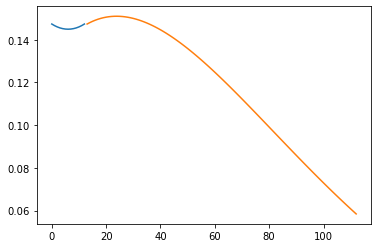

In [146]:
plt.plot(np.arange(13), np.abs(np.array([ 0.14735042-0.00000000e+00j, -0.21101475-1.18793907e-13j,
  0.14660762-9.49079862e-16j, -0.21210444-1.20829558e-13j,
  0.14600082-1.73328123e-15j, -0.2129974 -1.22482083e-13j,
  0.14552944-2.33999015e-15j, -0.21369277-1.23771161e-13j,
  0.14519306-2.76829625e-15j, -0.21418993-1.24678186e-13j,
  0.14499135-3.02805881e-15j, -0.21448841-1.25174245e-13j,
  0.14492414-3.09786441e-15j, -0.21458794-1.25305454e-13j,
  0.14499135-2.98808755e-15j, -0.21448841-1.25071707e-13j,
  0.14519306-2.69194191e-15j, -0.21418993-1.24473063e-13j,
  0.14552944-2.23076412e-15j, -0.21369277-1.23480604e-13j,
  0.14600082-1.61753546e-15j, -0.2129974 -1.22106110e-13j,
  0.14660762-8.42376230e-16j, -0.21210444-1.20394373e-13j,
  0.14735042+9.99140362e-17j, -0.21101475-1.18319540e-13j,
 -0.24585726+3.89277884e-02j, -0.03892779+5.25626618e-02j,
 -0.24585726+3.89277884e-02j, -0.03892779+5.25626618e-02j]))[:-4:2])
plt.plot(np.arange(13, 13+100), np.abs(lead_wavefuncr[:,0]))

In [162]:
L_out = [np.array([[ 9.86332899e-01-0.01348157j, -7.07632159e-15+0.06694227j],
       [ 0.00000000e+00+0.j        ,  9.86332899e-01+0.01348157j]]), np.array([[ 9.86332899e-01-0.01348157j, -7.07632159e-15+0.06694227j],
       [ 0.00000000e+00+0.j        ,  9.86332899e-01+0.01348157j]])]
X_out = [np.array([[-6.55901076e-01-0.26418512j, -2.64185121e-01+0.65590108j],
       [ 7.07106781e-01+0.j        , -7.75754461e-13+0.70710678j]]), np.array([[-6.55901076e-01-0.26418512j, -2.64185121e-01+0.65590108j],
       [ 7.07106781e-01+0.j        , -7.75754461e-13+0.70710678j]])]

In [163]:
L_out

[array([[ 9.86332899e-01-0.01348157j, -7.07632159e-15+0.06694227j],
        [ 0.00000000e+00+0.j        ,  9.86332899e-01+0.01348157j]]),
 array([[ 9.86332899e-01-0.01348157j, -7.07632159e-15+0.06694227j],
        [ 0.00000000e+00+0.j        ,  9.86332899e-01+0.01348157j]])]

In [164]:
L_out.conj().T

AttributeError: 'list' object has no attribute 'conj'

In [165]:
Q = block_diag(*X_out)
L = block_diag(*L_out)
q_e_ori = np.array([-0.24585726+3.89277884e-02j, -0.03892779+5.25626618e-02j,
 -0.24585726+3.89277884e-02j, -0.03892779+5.25626618e-02j])
lead_wavefuncr = []
for i in range(100):
    lead_wavefuncr.append((Q@np.linalg.matrix_power(L, i)@q_e_ori)[2:])
lead_wavefuncr = np.array(lead_wavefuncr)

In [166]:
L

array([[ 9.86332899e-01-0.01348157j, -7.07632159e-15+0.06694227j,
         0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
       [ 0.00000000e+00+0.j        ,  9.86332899e-01+0.01348157j,
         0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
       [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
         9.86332899e-01-0.01348157j, -7.07632159e-15+0.06694227j],
       [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
         0.00000000e+00+0.j        ,  9.86332899e-01+0.01348157j]])

In [167]:
L.conj().T

array([[ 9.86332899e-01+0.01348157j,  0.00000000e+00-0.j        ,
         0.00000000e+00-0.j        ,  0.00000000e+00-0.j        ],
       [-7.07632159e-15-0.06694227j,  9.86332899e-01-0.01348157j,
         0.00000000e+00-0.j        ,  0.00000000e+00-0.j        ],
       [ 0.00000000e+00-0.j        ,  0.00000000e+00-0.j        ,
         9.86332899e-01+0.01348157j,  0.00000000e+00-0.j        ],
       [ 0.00000000e+00-0.j        ,  0.00000000e+00-0.j        ,
        -7.07632159e-15-0.06694227j,  9.86332899e-01-0.01348157j]])

In [144]:
lead_wavefuncr[:,0]

array([0.14735042-1.23261740e-09j, 0.14801888-1.27805228e-09j,
       0.14861476-1.32179094e-09j, 0.14913981-1.36386304e-09j,
       0.14959573-1.40429798e-09j, 0.14998422-1.44312504e-09j,
       0.15030697-1.48037324e-09j, 0.15056561-1.51607144e-09j,
       0.15076179-1.55024827e-09j, 0.15089712-1.58293217e-09j,
       0.15097319-1.61415135e-09j, 0.15099157-1.64393381e-09j,
       0.1509538 -1.67230730e-09j, 0.15086142-1.69929937e-09j,
       0.15071593-1.72493731e-09j, 0.15051883-1.74924820e-09j,
       0.15027156-1.77225884e-09j, 0.14997558-1.79399585e-09j,
       0.1496323 -1.81448555e-09j, 0.14924314-1.83375400e-09j,
       0.14880947-1.85182705e-09j, 0.14833266-1.86873027e-09j,
       0.14781403-1.88448898e-09j, 0.14725491-1.89912823e-09j,
       0.1466566 -1.91267283e-09j, 0.14602037-1.92514726e-09j,
       0.14534749-1.93657583e-09j, 0.14463918-1.94698252e-09j,
       0.14389667-1.95639102e-09j, 0.14312115-1.96482482e-09j,
       0.14231379-1.97230707e-09j, 0.14147576-1.9788606

In [107]:
np.around((Phi.conj().T@Phi), 2)

array([[1.86+0.j, 0.35-0.j, 0.  +0.j, 0.  +0.j],
       [0.35+0.j, 0.14+0.j, 0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 1.86+0.j, 0.35-0.j],
       [0.  +0.j, 0.  +0.j, 0.35+0.j, 0.14+0.j]])

In [108]:
np.around(Phi, 2)

array([[-0.9 +0.34j, -0.1 +0.25j,  0.  +0.j  ,  0.  +0.j  ],
       [ 0.71+0.66j, -0.  +0.26j,  0.  +0.j  ,  0.  +0.j  ],
       [ 0.  +0.j  ,  0.  +0.j  , -0.9 +0.34j, -0.1 +0.25j],
       [ 0.  +0.j  ,  0.  +0.j  ,  0.71+0.66j, -0.  +0.26j]])

In [109]:
L_out

array([[0.9863329-0.01348157j, 0.       +0.j        ,
        0.       +0.j        , 0.       +0.j        ],
       [0.       +0.j        , 0.9863329+0.01348157j,
        0.       +0.j        , 0.       +0.j        ],
       [0.       +0.j        , 0.       +0.j        ,
        0.9863329-0.01348157j, 0.       +0.j        ],
       [0.       +0.j        , 0.       +0.j        ,
        0.       +0.j        , 0.9863329+0.01348157j]])

In [110]:
Phi[0].conj().T@Phi[3]

0j

In [173]:
N = Phi.conj().T @ Phi

lmb = np.diagonal(L_out)
for i, l1 in enumerate(lmb):
    for j, l2 in enumerate(lmb):
        ll = np.conj(l1) * l2
        N[i, j] *= ll / (1 - ll)
#print('new N')
#print(N)

for i, psi in enumerate(psi_alpha_0.T): #loop if degeneracy
    #print(i)
    #print(psi)
    a = q_e[:, i]
    #print(a)
    norm = psi.conj().T @ psi
    #print(norm)
    norm += a.conj().T @ N @ a
    #print(norm)
    norm = np.sqrt(norm)
    print(norm)

(1+1.0408340855860843e-17j)


In [174]:
psi_alpha_0

array([[ 0.05366533-1.97573591e-19j],
       [-0.07685201-4.32647056e-14j],
       [ 0.0533948 -3.45853441e-16j],
       [-0.07724888-4.40060924e-14j],
       [ 0.0531738 -6.31460400e-16j],
       [-0.0775741 -4.46079443e-14j],
       [ 0.05300213-8.52424421e-16j],
       [-0.07782735-4.50774283e-14j],
       [ 0.05287961-1.00841394e-15j],
       [-0.07800842-4.54077678e-14j],
       [ 0.05280615-1.10301974e-15j],
       [-0.07811713-4.55884334e-14j],
       [ 0.05278167-1.12844299e-15j],
       [-0.07815337-4.56362198e-14j],
       [ 0.05280615-1.08846212e-15j],
       [-0.07811713-4.55510889e-14j],
       [ 0.05287961-9.80605534e-16j],
       [-0.07800842-4.53330617e-14j],
       [ 0.05300213-8.12644074e-16j],
       [-0.07782735-4.49716069e-14j],
       [ 0.0531738 -5.89305549e-16j],
       [-0.0775741 -4.44710142e-14j],
       [ 0.0533948 -3.06991756e-16j],
       [-0.07724888-4.38475971e-14j],
       [ 0.05366533+3.61913266e-17j],
       [-0.07685201-4.30919402e-14j]])

In [28]:
q_e

array([[-0.10516328+0.03270303j],
       [-0.00542438+0.00732433j],
       [-0.10516328+0.03270303j],
       [-0.00542438+0.00732433j]])

In [175]:
q_e

array([[-0.05434258-0.03335044j],
       [-0.03794712+0.0512385j ],
       [-0.05434258-0.03335044j],
       [-0.03794712+0.0512385j ]])

In [6]:
# Copyright 2011-2019 Kwant authors.
#
# This file is part of Kwant.  It is subject to the license terms in the file
# LICENSE.rst found in the top-level directory of this distribution and at
# http://kwant-project.org/license.  A list of Kwant authors can be found in
# the file AUTHORS.rst at the top-level directory of this distribution and at
# http://kwant-project.org/authors.

# This is the feature version due to Joseph Weston taken from
#https://gitlab.kwant-project.org/jbweston/kwant/-/blob/feature/boundstate/kwant/physics/boundstate.py
#This version of the boundstate algorithm, albeit it has a lot of internal functions and was a little bit more
#opaque to look into, has a much more efficient root finder than the original version due to Mathieu Istas,
#posted below. We calculate the boundstate energies in our system using these methods first. In order to construct
#lead wavefunctions beyond the first unit cell, we then put the energies into the Istas version.

from packaging import version

import numpy as np
import scipy.linalg
import scipy.optimize
import scipy.sparse as sp

__all__ = ["find_boundstates"]

# TODO: remove this when we depend on scipy > 1.1
#1.3.1 here
if version.parse(scipy.__version__) > version.parse("1.1"):
    null_space = scipy.linalg.null_space
else:

    def null_space(A, rcond=None):
        u, s, vh = scipy.linalg.svd(A, full_matrices=True)
        M, N = u.shape[0], vh.shape[1]
        if rcond is None:
            rcond = np.finfo(s.dtype).eps * max(M, N)
        tol = np.amax(s) * rcond
        num = np.sum(s > tol, dtype=int)
        Q = vh[num:, :].T.conj()
        return Q


# If available, use MUMPS support for shift-inverse sparse diagonalization
# Can import mumps alright.
try:
    from kwant.linalg import mumps
except ImportError:
    sparse_diag = sp.linalg.eigsh
else:

    class _LuInv(sp.linalg.LinearOperator):
        def __init__(self, A):
            inst = mumps.MUMPSContext()
            inst.analyze(A)
            inst.factor(A)
            self.solve = inst.solve
            super().__init__(A.dtype, A.shape)

        def _matvec(self, x):
            return self.solve(x.astype(self.dtype))

    def sparse_diag(matrix, k, sigma, **kwargs):
        if sigma == 0:
            shifted_matrix = matrix
        else:
            shifted_matrix = matrix - sigma * sp.identity(matrix.shape[0])
        return sp.linalg.eigsh(matrix, k, sigma=sigma, OPinv=_LuInv(shifted_matrix),
                               **kwargs)

"""syst: kwant.system.FiniteSystem
"""

def find_boundstates(
    syst,
    min_energy,
    max_energy,
    params=None,
    sparse=True,
    check_hermiticity=True,
    rtol=1e-3,
):
    """Return boundstates of an open system in an energy window

    Parameters
    ----------
    syst : kwant.system.FiniteSystem
        Must have leads.
    min_energy, max_energy : float
        The lower and upper bounds in energy to search for boundstates.
    params : dict, optional
        The keyword arguments to 'syst'.
    sparse : bool, default: True
        If True use sparse linear algebra, otherwise use dense.
    check_hermiticity : bool, default: True
        If True, checks the Hermiticity of the system Hamiltonian
    rtol : float, default: 1E-3
        boundstates that are closer together than
        'rtol * (max_energy - min_energy)' may be missed.

    Returns
    -------
    energies : 1D float array
        The energies of the bound states.
    wavefunctions : 2D complex array
        The columns are the bound state wavefunctions defined
        over the scattering region.
    """

    # TODO: apply lru_cache to this once
    # https://github.com/scipy/scipy/issues/10846 is solved.
    def min_eigenvalue(energy):
        H_eff = make_linsys(
            syst,
            energy,
            params=params,
            sparse=sparse,
            check_hermiticity=check_hermiticity,
        )
        try:
            if sparse:
                if H_eff.shape[0] <= 2:
                    raise ValueError(
                        "The system is too small to use sparse diagonalization. "
                        "Try setting 'sparse=False'."
                    )
                vals = sparse_diag(
                    H_eff.tocsc(), k=1, sigma=1e-10, which="LM", return_eigenvectors=False
                )
                '''print('energy:')
                print(energy)
                print('Direct Diagonalisation:')
                print(spi.linalg.eigvals(H_eff.toarray()))
                print('sparce f:')
                print(vals[np.argmin(np.abs(vals))]'''
                return vals[0]
            else:
                vals = np.linalg.eigvalsh(H_eff)
                which = np.argmin(np.abs(vals))
                return vals[which]
        except RuntimeError:  # Some problem diagonalizing
            return np.inf

    if syst.site_ranges is not None:
        tot_norbs = syst.site_ranges[-1][-1]
    else:
        _, norbs = syst.hamiltonian_submatrix(params=params, return_norb=True)[:2]
        tot_norbs = sum(norbs)

    # Grid the energy window and search for roots in the sub-windows
    # where the min-eigenvalue changes sign. These will either be
    # true roots or discontinuities. Note that if there are >1 roots
    # in the same sub-window then at least one of them will be missed.
    '''print('f(0):')
    print(min_eigenvalue(0))
    print('f(1e-16)')
    print(min_eigenvalue(1e-16))
    print('f(3e-16)')
    print(min_eigenvalue(3e-16))
    print('f(1e-15)')
    print(min_eigenvalue(1e-15))'''
    
    '''print('f(0):')
    print(min_eigenvalue(0.))'''
    #print('tot_norbs')
    #print(tot_norbs)
    
    energies = np.linspace(
        min_energy, max_energy, int((max_energy - min_energy) / rtol)
    )
    intervals = zip(energies, energies[1:])
    
    '''f_E = []
    for e in energies:
        print(e)
        f_E.append(min_eigenvalue(e))
    plt.scatter(energies, f_E)'''
    
    candidates = []
    for a, b in intervals:
        try:
            if np.sign(min_eigenvalue(a)) != np.sign(min_eigenvalue(b)):
                candidate = scipy.optimize.brentq(min_eigenvalue, a, b)
                candidates.append(candidate)
        except RuntimeError: #some problems with lead modes
            continue
    
    
    # Check which candidate points give actual boundstates.
    energies = []
    states = []
    for energy in candidates:
        vecs = extract_boundstates(syst, energy, params=params, sparse=sparse)
        # vecs.shape[1] == 0 if there were no boundstates found
        energies.append([energy] * vecs.shape[1])
        # Here we discard the mode part of the solution just to
        # make the output format more uniform (wavefunction has
        # same number of components at all energies).
        states.append(vecs[:tot_norbs, :])

    if not energies:
        return np.empty((0,)), np.empty((tot_norbs, 0))
    else:
        return np.hstack(energies), np.hstack(states)


def extract_boundstates(
    syst, energy=0, params=None, sparse=True, check_hermiticity=True, tol=1e-8
):
    """Return any true boundstates of 'syst' at 'energy'

    Params
    ------
    syst : kwant.FiniteSystem
        Must have leads
    energy : float
    params : dict, optional
        Keyword arguments to 'syst'
    sparse : bool, default: True
        If True, returns sparse matrices
    check_hermiticity : bool, default: True
        If True, check the system Hamiltonian for hermiticity

    Returns
    -------
    vecs : 2D array
        The columns are bound state wavefunctions.
        The first N rows is in the tight-binding basis of the
        scattering region, and the remaining rows are in the
        basis of stabilized evanescent modes of the leads.

    Notes
    -----
    We diagonalize the linear system returned by 'make_linsys', and
    search for zero eigenvalues. We then look for vectors in the basis
    of zero-eigenvalue eigenvectors that satisfy the bound state condition,
    eq. 19 of https://doi.org/10.21468/SciPostPhys.4.5.026.
    """

    lhs, T = make_linsys(
        syst,
        energy,
        params=params,
        sparse=sparse,
        check_hermiticity=check_hermiticity,
        return_validation=True,
        which="hermitian",
    )

    if sparse:
        if lhs.shape[0] <= 2:
            raise ValueError(
                "The system is too small to use sparse diagonalization. "
                "Try setting 'sparse=False'."
            )
        k = min(6, lhs.shape[0] - 2)  # 6 is the default for sp.linalg.eigsh
        try_again = True
        # Solve the eigenproblem with successively large values of 'k' until
        # we get all the zero eigenvalues. (In most cases this loop will
        # run once).
        while try_again:
            vals, vecs = sparse_diag(lhs.tocsc(), k=k, sigma=1e-10, which="LM")
            zeros = np.abs(vals) < tol  # TODO: make this check better
            if not np.all(zeros):  # we have found all the zero eigenvalues
                try_again = False
            else:
                k *= 2  # try again with twice the number of eigenvalues
                if k >= lhs.shape[0] - 1:
                    raise ValueError(
                        "More eigenvalues are 0 than can be obtained by "
                        "sparse diagonalization. Try setting 'sparse=False'."
                    )
    else:
        vals, vecs = np.linalg.eigh(lhs)
        zeros = np.abs(vals) < tol  # TODO make this check better

    if not np.any(zeros):
        return np.empty((lhs.shape[0], 0))


    zero_vecs = vecs[:, zeros]
    # To find the true boundstates we find the null space of the operator
    # in eq 19 (T) in the basis of zero-eigenvalue vectors.
    p = T @ zero_vecs
    if np.allclose(p, 0):
        # 'zero_vecs' are already a basis for the null space of T
        return zero_vecs
    else:
        # TODO: not sure about this value for 'rcond', we need to ensure
        #       that rcond is sufficiently large in the case that p is
        #       zero (i.e. zero_vecs are individually boundstates).
        bound_states = null_space(p, rcond=tol / np.max(np.abs(p)))
        # transform back to original basis
        # TODO: rotate the basis so the bound states have the correct symmetries
        return np.asarray(zero_vecs @ bound_states)


def make_linsys(
    syst,
    energy=0,
    params=None,
    sparse=True,
    check_hermiticity=True,
    return_validation=False,
    which="hermitian",
):
    """Return the linear system for finding boundstates

    Returns ether the linear system defined in equation 12 or equation 11
    of https://doi.org/10.21468/SciPostPhys.4.5.026, and the linear
    operator defined in equation 19 of the same article.

    Params
    ------
    syst : kwant.FiniteSystem
        Must have leads
    energy : float
    params : dict, optional
        Keyword arguments to 'syst'
    sparse : bool, default: True
        If True, returns sparse matrices
    check_hermiticity : bool, default: True
        If True, check the system Hamiltonian for hermiticity
    return_validation: bool, default: False
        If True, also return the linear operator used for
        checking for true bound states (equation 19 of the article).
    which : str, default: "hermitian"
        Which linear system to return. If "hermitian" returns the
        linear system defined in equation 12, if "svd" returns
        the linear system defined in equation 11.

    Returns
    -------
    lhs : 2D array or sparse matrix
        The linear system for finding boundstates
    T : 2D array or sparse matrix
        A linear operator for checking bound states.
        zero-eigenvalue eigenvectors of 'lhs' that are in the
        null-space of 'T' are true bound states. Only returned
        if 'return_validation' is True.
    """
    if not syst.leads:
        raise ValueError("'syst' must have leads attached")
    if any(interface.shape[0] == 0 for interface in syst.lead_interfaces):
        raise ValueError(
            "All the leads of 'syst' must have non-zero " "inter-cell hopping"
        )

    lhs, norb = syst.hamiltonian_submatrix(
        params=params, sparse=sparse, return_norb=True
    )[:2]
    offsets = np.empty(norb.shape[0] + 1, int)
    offsets[0] = 0
    offsets[1:] = np.cumsum(norb)
    scattering_region_norbs = offsets[-1]

    if check_hermiticity and len(lhs.data):
        rtol = 1e-13
        atol = 1e-300
        tol = rtol * np.max(np.abs(lhs.data)) + atol
        if np.any(np.abs((lhs - lhs.T.conj()).data) > tol):
            raise ValueError(
                "System Hamiltonian is not Hermitian. "
                "Use option `check_hermiticity=False` "
                "if this is intentional."
            )

    if sparse:
        lhs = lhs - energy * sp.identity(lhs.shape[0])
    else:
        lhs.flat[:: (offsets[-1] + 1)] -= energy

    phi_e = []
    svd_vs = []
    transfs = []
    for leadnum, interface in enumerate(syst.lead_interfaces):
        lead = syst.leads[leadnum]
        _, stab = lead.modes(energy, params=params)
        svd_v = stab.sqrt_hop
        # Evanescent modes (schur vectors) are stored after
        # the 2*nmodes propagating (in/out) modes
        evan_vecs = slice(2 * stab.nmodes, None)
        u_out = stab.vecs[:, evan_vecs]
        ulinv_out = stab.vecslmbdainv[:, evan_vecs]

        # Construct a matrix of 1's that translates the
        # inter-cell hopping to a proper hopping
        # from the system to the lead.
        iface_orbs = np.r_[tuple(slice(offsets[i], offsets[i + 1]) for i in interface)]

        n_lead_orbs = svd_v.shape[0]
        if n_lead_orbs != len(iface_orbs):
            msg = (
                "Lead {0} has hopping with dimensions "
                "incompatible with its interface dimension."
            )
            raise ValueError(msg.format(leadnum))

        coords = np.r_[[np.arange(len(iface_orbs))], [iface_orbs]]
        transf = sp.csc_matrix(
            (np.ones(len(iface_orbs)), coords), shape=(iface_orbs.size, lhs.shape[0])
        )

        phi_e.append(ulinv_out)
        svd_vs.append(svd_v)
        # We are saving these for use in '_validation_operator', where we
        # expect each projector to project *from the scattering region only*,
        # hence the slice up to 'scattering_region_norbs'
        transfs.append(transf[:, :scattering_region_norbs])

        if which == "hermitian":
            A, B, C = _hermitian_matrices(svd_v, transf, u_out, ulinv_out)
        elif which == "svd":
            A, B, C = _svd_matrices(svd_v, transf, u_out, ulinv_out)
        else:
            raise ValueError("'which' must be 'hermitian' or 'svd'")

        if sparse:
            A = sp.csc_matrix(A)
            B = sp.csc_matrix(B)
            C = sp.csc_matrix(C)
            lhs = sp.bmat([[lhs, A], [B, C]])
        else:
            lhs = np.block([[lhs, A], [B, C]])

    if return_validation:
        return (
            lhs,
            _validation_operator(
                phi_e=phi_e,
                svd_vs=svd_vs,
                transfs=transfs,
                orb_offsets=offsets,
                sparse=sparse,
            ),
        )
    else:
        return lhs


# Equation 12
def _hermitian_matrices(svd_v, transf, u_out, ulinv_out):
    A = transf.T @ svd_v @ u_out
    B = A.conj().T
    C = -u_out.T.conj() @ ulinv_out
    return A, B, C


# Equation 11
def _svd_matrices(svd_v, transf, u_out, ulinv_out):
    A = transf.T @ svd_v @ u_out
    B = svd_v.conj().T @ transf
    C = -ulinv_out
    return A, B, C


# Equation 19
def _validation_operator(phi_e, svd_vs, transfs, orb_offsets, sparse):

    syst_size = orb_offsets[-1]
    mode_size = sum(phi.shape[1] for phi in phi_e)
    sol_size = syst_size + mode_size

    p_psi = sp.csc_matrix(
        (np.ones(syst_size), (np.arange(syst_size),) * 2), shape=(syst_size, sol_size)
    )
    p_q = sp.csc_matrix(
        (np.ones(mode_size), (np.arange(mode_size), np.arange(syst_size, sol_size))),
        shape=(mode_size, sol_size),
    )

    svd_v = np.vstack(svd_vs)
    transf = sp.vstack(transfs)
    # The states are the *columns*, so use hstack rather than vstack
    phi = np.hstack(phi_e)

    r = svd_v.conj().T @ (transf @ p_psi) - phi @ p_q

    if sparse:
        r = sp.csc_matrix(r)

    return r


In [12]:
# code chunk useful for selecting every n elements to separate the wavefunctions in the two leads.
def select_in_groups_strided(a, M, N): # Keep first M, delete next N and so on.
    K = M+N
    na = a.size
    nrows = (1+((na-1)//K))
    n = a.strides[0]
    out = np.lib.index_tricks.as_strided(a, shape=(nrows,K), strides=(K*n,n))
    N = M*(na//K) + (na - (K*(na//K)))
    return out[:,:M].ravel()[:N]

In [13]:
# returns the wave function in the leads up to a given last-cell magnitude, or a given number of cells.
def long_wf_in_leads(q_e, L_out, Phi, lead_no=1, fixed_no_cells=None, limit=100., no_orb=2):
    '''return wavefunction with leads with number of unit cells'''
    no_orb = int(no_orb)
    if fixed_no_cells is None:
        j=0
        quick_wf = wf_in_leads(q_e, L_out, Phi, 0)
        wave_func_array = quick_wf
        first_site_amplitude = quick_wf.T.conj()@quick_wf
        last_site_amplitude = first_site_amplitude
        while last_site_amplitude > first_site_amplitude/limit:
            j+=1
            quick_wfj = wf_in_leads(q_e, L_out, Phi, j)
            wave_func_array = np.vstack((wave_func_array, quick_wfj))
            last_site_amplitude = quick_wfj.T.conj()@quick_wfj
        wave_func_array = np.array(wave_func_array)
        if lead_no==0:
            return select_in_groups_strided(wave_func_array, no_orb, no_orb), wave_func_array.shape[0]/(no_orb*2)
        elif lead_no==1:
            return select_in_groups_strided(wave_func_array[no_orb:], no_orb, no_orb), wave_func_array.shape[0]/(no_orb*2)
    else:
        wave_func_array = wf_in_leads(q_e, L_out, Phi, 0)
        for i in range(0, fixed_no_cells):
            quick_wfj = wf_in_leads(q_e, L_out, Phi, i+1)
            wave_func_array = np.vstack((wave_func_array, quick_wfj))
        wave_func_array = np.array(wave_func_array)
        if lead_no==0:
            return select_in_groups_strided(wave_func_array, no_orb, no_orb), wave_func_array.shape[0]/(no_orb*2)
        elif lead_no==1:
            return select_in_groups_strided(wave_func_array[no_orb:], no_orb, no_orb), wave_func_array.shape[0]/(no_orb*2)

In [14]:
# re-inputs the bound-state energies into the Istas version bound-state code to extract lead wave functions.
# has a plot function inside to visualise the overall wave function of each state in each orbital.
# code not optimised. Only for showing the problem we have encountered with the algorithm.
def istas_scan(e_subarray, syst, params=None, all_out=False, no_orb=2):
    '''
    Extract the wavefunction, including the part in the leads, using the Istas bound state code, given
    a pre-calculated list of bound state energies for a system. Also renders a plot of the real-space
    probability distribution (each column for a different orbital, and each row for a different bound
    state. Empty subplots means that that Weston bound state is not recognised by Istas as a true bound state.)
    
            Parameters:
                    e_subarray (list-like): The pre-calculated boundstate energies
                    syst (Kwant.InfiniteSystem): The system with the correct parameter matching
                                                 the pre-calculated bound states.
                    params (dictionary): Parameters for syst.
                    all_out (bool): whether to output all parts of the wavefunction, or just the part in the right lead
                                    (This was for our own purposes where for our matrix element calculations only the
                                    right lead has non-zero contributions)
                    no_orb (int): No. of orbitals per unit cell.

            Returns:
                    e_compare (list of floats): A list of bound state energies calculated by Istas.
                    wavefunc_lleads (list of arrays): A list of left lead (index 0) wavefunctions, wavefunc_lleads[i]
                                                      being the wavefunction for the state at E=e_compare[i]
                    wavefunc_rleads (list of arrays): Same as above, except these are the wavefunctions in the right lead.
                    wavefunc_scat (list of arrays): Same as above but for the scattering region.
                    no_cells_lleads (list of floats): Number of unit cells I have calculated up to in the left lead.
                                                      I have selected the arbitrary threshold of calculating further unit
                                                      cells until the probability of that cell is 10,000 lower than the
                                                      probability of the first unit cell in the lead.
                    no_cells_rleads (list of floats): Same as above but for the right lead.
    '''
    no_orb = int(no_orb)
    no_states = len(e_subarray)
    e_division = np.array([[e_subarray[i], e_subarray[i]] for i in range(len(e_subarray))])
    e_compare = []
    wavefunc_lleads = []
    no_cells_lleads = []
    wavefunc_rleads = []
    no_cells_rleads = []
    wavefunc_scat = []
    fig, axs = plt.subplots(no_states, 2, figsize=(15,15))
    for i in range(len(e_subarray)):
        print(i)
        print(e_division[i])
        try:
            E, psi_alpha_0, q_e, L_out, Phi = bound_state(syst, e_division[i], return_wf=True, params=params)
        except:
            continue
        e_compare.append(E)
        wavefunc_scat.append(psi_alpha_0)
        trial_wfr, no_cellsr = long_wf_in_leads(q_e, L_out, Phi, lead_no=1, limit=10000., no_orb=no_orb)
        trial_wfl, no_cellsl = long_wf_in_leads(q_e, L_out, Phi, lead_no=0, limit=10000., no_orb=no_orb)
        no_cells_lleads.append(no_cellsl)
        no_cells_rleads.append(no_cellsr)
        wavefunc_lleads.append(trial_wfl)
        wavefunc_rleads.append(trial_wfr)
        #print(trial_wf)
        #print(trial_wfr)
        #print(trial_wfr.shape)
        #print(trial_wfr.shape[0]/8)
        #print(psi_alpha_0.shape)
        for k in range(no_orb):
            ax = axs[i][k]
            ax.plot(np.arange(-trial_wfl.shape[0]/no_orb+1, 1), np.array([np.abs(trial_wfl[j*no_orb+k])**2. for j in range(int(trial_wfl.shape[0]/no_orb)-1, -1, -1)]))
                #[trial_wfl[j*no_orb:(j+1)*no_orb].T.conj()@trial_wfl[j*no_orb:(j+1)*no_orb] for j in range(int(trial_wfl.shape[0]/no_orb)-1, -1, -1)]))
            ax.plot(np.arange(psi_alpha_0.shape[0]/no_orb), np.array([np.abs(psi_alpha_0[j*no_orb+k,0])**2. for j in range(int(psi_alpha_0.shape[0]/no_orb))]))
                #psi_alpha_0[j*no_orb:(j+1)*no_orb,0].T.conj()@psi_alpha_0[j*no_orb:(j+1)*no_orb,0] for j in range(int(psi_alpha_0.shape[0]/no_orb))]))
            ax.plot(np.arange(psi_alpha_0.shape[0]/no_orb-1, trial_wfr.shape[0]/no_orb+psi_alpha_0.shape[0]/no_orb-1), np.array([np.abs(trial_wfr[j*no_orb+k])**2. for j in range(int(trial_wfr.shape[0]/no_orb))]))
            #ax.plot(np.arange(-trial_wfl.shape[0]/8+1, 0), np.array([np.abs(trial_wfl[j*8+k])**2. for j in range(int(trial_wfl.shape[0]/8)-1, 0, -1)]))
            #ax.plot(np.arange(psi_alpha_0.shape[0]/8), np.array([np.abs(psi_alpha_0[j*8+k,0])**2. for j in range(int(psi_alpha_0.shape[0]/8))]))
            #ax.plot(np.arange(psi_alpha_0.shape[0]/8, trial_wfr.shape[0]/8+psi_alpha_0.shape[0]/8-1), np.array([np.abs(trial_wfr[j*8+k])**2. for j in range(int(trial_wfr.shape[0]/8)-1)]))
            #plt.xlim(-100, 100)
            #plt.ylim(0, 0.002)
        fig.text(0.5, 0.08, 'Orbitals', ha='center', fontsize=18)
        fig.text(0.04, 0.5, 'Bound states', va='center', rotation='vertical', fontsize=18)
        
        '''if i==0:
            fig, axs = plt.subplots(4, 2, figsize=(15,15))
            for k in range(0, 8):
                ax = axs.flatten()[k]
                ax.plot(np.arange(-trial_wfl.shape[0]/8+1, 0), np.array([np.abs(trial_wfl[j*8+k])**2. for j in range(int(trial_wfl.shape[0]/8)-1, 0, -1)]))
                ax.plot(np.arange(psi_alpha_0.shape[0]/8), np.array([np.abs(psi_alpha_0[j*8+k,0])**2. for j in range(int(psi_alpha_0.shape[0]/8))]))
                ax.plot(np.arange(psi_alpha_0.shape[0]/8, trial_wfr.shape[0]/8+psi_alpha_0.shape[0]/8-1), np.array([np.abs(trial_wfr[j*8+k])**2. for j in range(int(trial_wfr.shape[0]/8)-1)]))
                #plt.xlim(-100, 100)
                #plt.ylim(0, 0.002)
                ax.axhline(0, c='k', alpha=0.7)
            print('left lead')
            print(np.array([trial_wfl[j*1:(j+1)*1].T.conj()@trial_wfl[j*1:(j+1)*1] for j in range(int(trial_wfl.shape[0]/1)-1, -1, -1)]))
            plt.plot(np.arange(-trial_wfl.shape[0]/1+1, 1), np.array([trial_wfl[j*1:(j+1)*1].T.conj()@trial_wfl[j*1:(j+1)*1] for j in range(int(trial_wfl.shape[0]/1)-1, -1, -1)]))
            plt.plot(np.arange(psi_alpha_0.shape[0]/1), np.array([psi_alpha_0[j*1:(j+1)*1,0].T.conj()@psi_alpha_0[j*1:(j+1)*1,0] for j in range(int(psi_alpha_0.shape[0]/1))]))
            plt.plot(np.arange(psi_alpha_0.shape[0]/1-1, trial_wfr.shape[0]/1+psi_alpha_0.shape[0]/1-1), np.array([trial_wfr[j*1:(j+1)*1].T.conj()@trial_wfr[j*1:(j+1)*1] for j in range(int(trial_wfr.shape[0]/1))]))
            #plt.xlim(-100, 100)'''
        #print(psi_alpha_0[-8:])
        #print(wf_in_leads(q_e, L_out, Phi, 0)[-8:])
        #print(syst.leads[1].inter_cell_hopping().T.conj()@psi_alpha_0[-8:])
        #print(psi_alpha_0[-8:]/wf_in_leads(q_e, L_out, Phi, 0)[-8:])
        #print(i)
        #print(E)
        #print(psi_alpha_0)
        #print(q_e)
        #print(np.abs(np.array([L_out[i,i] for i in range(len(L_out))])))
        #print(Phi[:,3])
    #print(no_cells_rleads)
    no_cell_runiform = int(max(no_cells_rleads)/2)
    #print('no_cell_runiform')
    #print(no_cell_runiform)
    e_compare = []
    wavefunc_lleads = []
    no_cells_lleads = []
    wavefunc_rleads = []
    no_cells_rleads = []
    wavefunc_scat = []
    for i in range(len(e_subarray)):
        #print(i)
        #print(e_division[i])
        try:
            E, psi_alpha_0, q_e, L_out, Phi = bound_state(syst, e_division[i], return_wf=True, params=params)
        except:
            continue
        e_compare.append(E)
        wavefunc_scat.append(psi_alpha_0)
        trial_wfr, no_cellsr = long_wf_in_leads(q_e, L_out, Phi, lead_no=1, fixed_no_cells=no_cell_runiform, no_orb=no_orb)
        trial_wfl, no_cellsl = long_wf_in_leads(q_e, L_out, Phi, lead_no=0, fixed_no_cells=no_cell_runiform, no_orb=no_orb)
        no_cells_lleads.append(no_cellsl)
        no_cells_rleads.append(no_cellsr)
        wavefunc_lleads.append(trial_wfl)
        wavefunc_rleads.append(trial_wfr)
    
    if all_out:
        return e_compare, wavefunc_lleads, wavefunc_rleads, wavefunc_scat, no_cells_lleads, no_cells_rleads
    else:
        return e_compare, wavefunc_rleads, no_cells_rleads

In [15]:
# transform from vecs and vecslmbdainv of kwant.modes to eigenvectors@eigenvalues and eigenvectors following
# https://gitlab.kwant-project.org/kwant/kwant/-/merge_requests/39
def inverse_A_B_alt(syst, vecslmbdainv, vecs, params):
    hop = syst.leads[0].inter_cell_hopping(params=params)
    B = np.sqrt(np.linalg.norm(hop))*np.identity(hop.shape[0])
    A = hop@np.linalg.inv(B).T.conj()
    B_dagger_inv = np.linalg.inv(B.T.conj())
    A_dagger_inv = np.linalg.inv(A.T.conj())
    phi_lmbda = A_dagger_inv@vecs
    phi = B_dagger_inv@vecslmbdainv
    return phi, phi_lmbda

In [16]:
# Get StabilisedModes given system and energy
def vecs_vecslmbdainv(syst, energy, params, lead_no=1):
    _, stab = syst.leads[lead_no].modes(energy, params=params)
    evan_vecs = slice(2 * stab.nmodes, None)
    u_out = stab.vecs[:, evan_vecs]
    ulinv_out = stab.vecslmbdainv[:, evan_vecs]
    return ulinv_out, u_out

In [7]:
import numpy as np
import kwant
from scipy import linalg
import matplotlib.colors as colors

In [177]:
params = dict(
    mu = 2.,
    A = 1,
    B_x=1,
    B_y=1,
    B_z=1
)

def make_system1(params, L=11):
    a = 1
    mu, A, B_x, B_y, B_z = params.values()
    
    lat = kwant.lattice.chain()
    syst = kwant.Builder()
    
    # Pauli matrices
    sigma_0 = np.array([[1, 0], [0, 1]])
    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_y = np.array([[0, -1j], [1j, 0]])
    sigma_z = np.array([[1, 0], [0, -1]])
    
    ham = (2.*A/(a**2.)-mu)*sigma_0
    hop = -A/(a**2.)*sigma_0
    
    ham_leads = ham + B_x*sigma_x + B_y*sigma_y + B_z*sigma_z
    hop_leads = hop
    
    syst[(lat(-1))] = ham_leads
    syst[(lat(x) for x in range(0, L))] = ham
    syst[(lat(L))] = ham_leads
    syst[((lat(x), lat(x+1)) for x in range(-1, L))] = hop
    
    sym_left = kwant.TranslationalSymmetry([-1])
    lead0 = kwant.Builder(sym_left)
    lead0[(lat(-2))] = ham_leads
    lead0[lat.neighbors()] = hop_leads
    sym_right = kwant.TranslationalSymmetry([1])
    lead1 = kwant.Builder(sym_right)
    lead1[(lat(L+1))] =  ham_leads
    lead1[lat.neighbors()] = hop_leads
    
    syst.attach_lead(lead0)
    syst.attach_lead(lead1)

    return syst.finalized()

syst = make_system1(params)

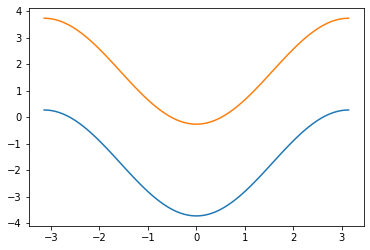

In [178]:
from matplotlib import pyplot as plt
bands=kwant.physics.Bands(syst.leads[1], params=params)
momenta=np.linspace(-np.pi,np.pi,101)
en=[bands(k) for k in momenta]
x=np.array(en)
en=(x)
plt.plot(momenta, en)
#plt.axhline(1.4)
plt.show()

In [179]:
energies_Weston, wavefunctions = find_boundstates(syst, -4, 4, rtol=1e-2, params=params)

In [180]:
energies_Weston

array([-2.30833431, -1.94025026, -1.76469903, -1.63067309, -1.4843453 ,
       -1.11739914, -0.82088082, -0.69059751, -0.27181163, -0.16712528,
        0.16712528,  0.27181163,  0.69059751,  0.82088082,  1.11739914,
        1.4843453 ,  1.63067309,  1.76469903,  1.94025026,  2.30833431])

0
[-2.30833431 -2.30833431]
lhs
(30, 28)
0.3673049643878748
1
[-1.94025026 -1.94025026]
lhs
(30, 28)
lhs
(30, 28)
sing values
[4.35408084e+00 4.35312816e+00 3.88001798e+00 3.84256529e+00
 3.70290069e+00 3.58763990e+00 3.41945308e+00 3.22448163e+00
 3.04668245e+00 2.78657948e+00 2.60730258e+00 2.30407682e+00
 2.12914086e+00 1.80844289e+00 1.64649246e+00 1.33701832e+00
 1.21776804e+00 9.85406956e-01 9.80283720e-01 8.69187682e-01
 8.63087923e-01 7.40694573e-01 6.26817299e-01 4.46135935e-01
 3.17439619e-01 1.74425772e-01 1.03361401e-01 1.69298515e-15]
[-0.03513802-0.00000000e+00j -0.01286141-1.28614094e-02j
 -0.11862953+1.73472348e-17j -0.04342142-4.34214228e-02j
 -0.19503296-4.16333634e-17j -0.07138702-7.13870175e-02j
 -0.25978322-7.28583860e-17j -0.09508726-9.50872564e-02j
 -0.30901149+2.65629532e-17j -0.11310606-1.13106056e-01j
 -0.33977641+1.17961196e-16j -0.1243668 -1.24366799e-01j
 -0.35023978+6.78168459e-17j -0.12819666-1.28196657e-01j
 -0.33977641-1.27339545e-16j -0.1243668 -1.2436

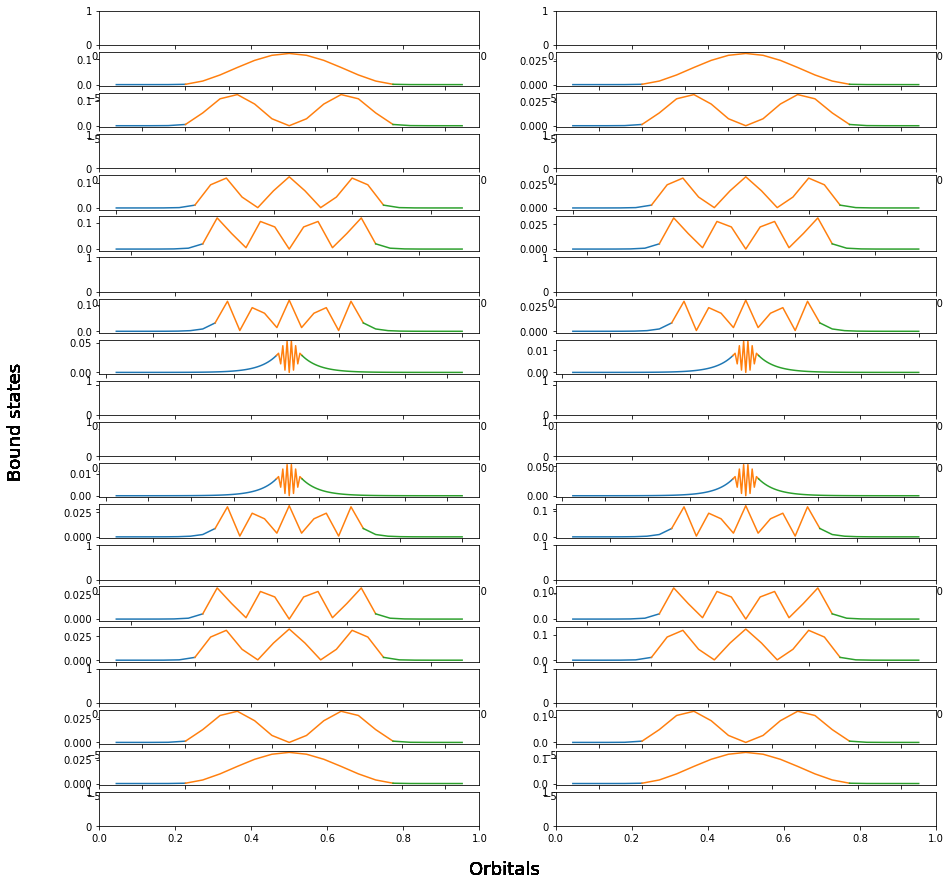

In [181]:
energies_Istas, wavefunc_lleads, wavefunc_rleads, wavefunc_scat, no_cells_lleads, no_cells_rleads = istas_scan(energies_Weston, syst, params=params, all_out=True)

In [82]:
params = dict(
    mu = 0.,
    A = 1,
    Delta=1e-3
)

def make_system1(params, L=11):
    a = 1
    mu, A, Delta = params.values()
    
    lat = kwant.lattice.chain()
    syst = kwant.Builder()
    
    # Pauli matrices
    sigma_0 = np.array([[1, 0], [0, 1]])
    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_y = np.array([[0, -1j], [1j, 0]])
    sigma_z = np.array([[1, 0], [0, -1]])
    
    ham = (2.*A/(a**2.)-mu)*sigma_z
    hop = -A/(a**2.)*sigma_z
    
    ham_leads = ham + Delta*sigma_x
    hop_leads = hop
    
    syst[(lat(-1))] = ham_leads
    syst[(lat(x) for x in range(0, L))] = ham
    syst[(lat(L))] = ham_leads
    syst[((lat(x), lat(x+1)) for x in range(-1, L))] = hop
    
    sym_left = kwant.TranslationalSymmetry([-1])
    lead0 = kwant.Builder(sym_left)
    lead0[(lat(-2))] = ham_leads
    lead0[lat.neighbors()] = hop_leads
    sym_right = kwant.TranslationalSymmetry([1])
    lead1 = kwant.Builder(sym_right)
    lead1[(lat(L+1))] =  ham_leads
    lead1[lat.neighbors()] = hop_leads
    
    syst.attach_lead(lead0)
    syst.attach_lead(lead1)

    return syst.finalized()

syst = make_system1(params)

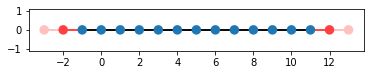

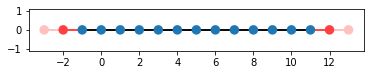

In [83]:
kwant.plot(syst)

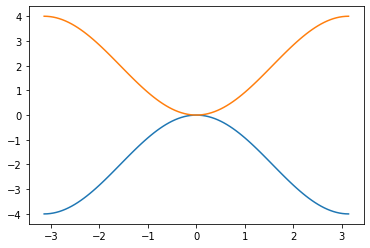

In [84]:
from matplotlib import pyplot as plt
bands=kwant.physics.Bands(syst.leads[1], params=params)
momenta=np.linspace(-np.pi,np.pi,101)
en=[bands(k) for k in momenta]
x=np.array(en)
en=(x)
plt.plot(momenta, en)
#plt.axhline(1.4)
plt.show()

### Scanning boundstate energies and extracting boundstate wavefunctions

In [20]:
energies_Weston, wavefunctions = find_boundstates(syst, -2e-3, 2e-3, rtol=1e-5, params=params)

In [21]:
energies_Weston

array([-0.00092758,  0.00092758])

0
[-0.00092758 -0.00092758]
lhs
(30, 30)
lhs
(30, 30)
sing values
[3.95683300e+00 3.95554814e+00 3.82684915e+00 3.82653663e+00
 3.61850373e+00 3.61592130e+00 3.33949386e+00 3.33445621e+00
 3.00186438e+00 2.99476317e+00 2.62023296e+00 2.61200467e+00
 2.21117419e+00 2.20317085e+00 1.79251364e+00 1.78629182e+00
 1.38255832e+00 1.37961908e+00 1.00082098e+00 9.99294043e-01
 6.66219464e-01 6.59598093e-01 3.90128395e-01 3.78479629e-01
 1.84275359e-01 1.68445704e-01 5.70737463e-02 3.89804619e-02
 1.02177899e-02 3.17696603e-13]
[ 0.14735042-0.00000000e+00j -0.21101475-1.18793907e-13j
  0.14660762-9.49079862e-16j -0.21210444-1.20829558e-13j
  0.14600082-1.73328123e-15j -0.2129974 -1.22482083e-13j
  0.14552944-2.33999015e-15j -0.21369277-1.23771161e-13j
  0.14519306-2.76829625e-15j -0.21418993-1.24678186e-13j
  0.14499135-3.02805881e-15j -0.21448841-1.25174245e-13j
  0.14492414-3.09786441e-15j -0.21458794-1.25305454e-13j
  0.14499135-2.98808755e-15j -0.21448841-1.25071707e-13j
  0.14519306-2.6919

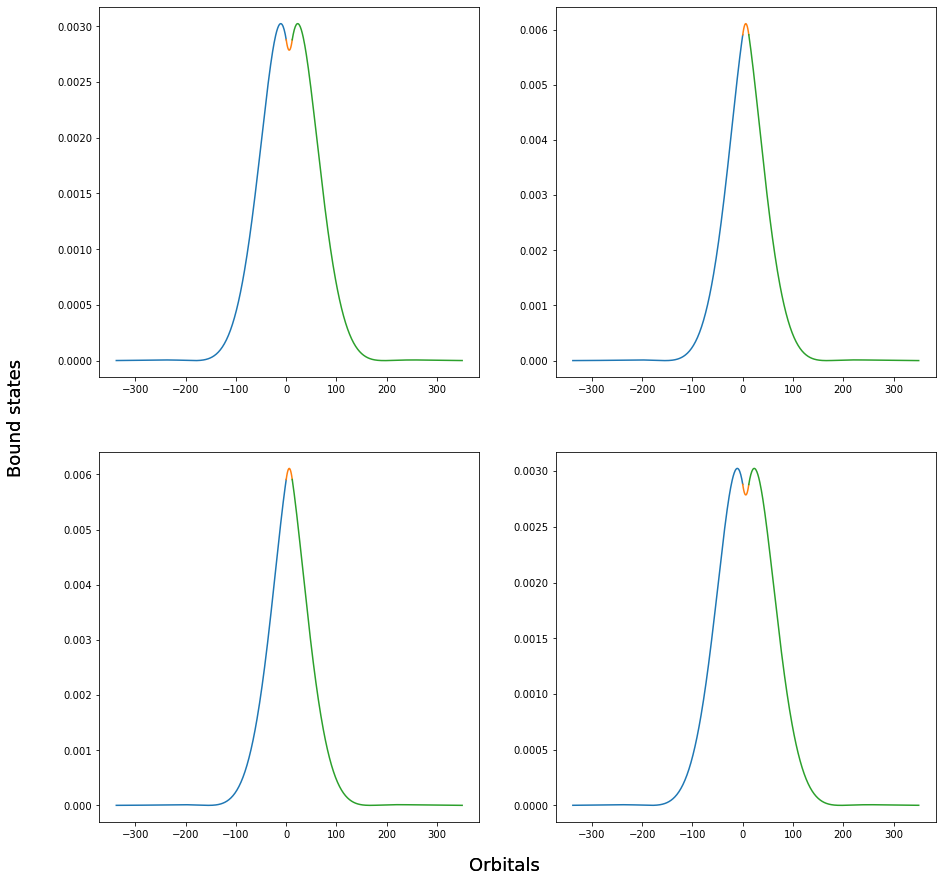

In [176]:
energies_Istas, wavefunc_lleads, wavefunc_rleads, wavefunc_scat, no_cells_lleads, no_cells_rleads = istas_scan(energies_Weston, syst, params=params, all_out=True)

In [113]:
q_e

array([[-0.07871339+0.02447781j],
       [-0.00406008+0.00548217j],
       [-0.07871339+0.02447781j],
       [-0.00406008+0.00548217j]])